In [1]:
%pylab inline
import numpy as np
np.set_printoptions(precision=4, linewidth=150)

from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

import lal
import lalsimulation

import pycbc.waveform
import pycbc.filter
import pycbc.types
import pycbc.psd

Populating the interactive namespace from numpy and matplotlib



In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

# Load GPSplineSurrogate

Choosing npoints to be as small as possible has a large impact on the speed of the surrogate 200 or 1000 is much better than 10,000.

In [3]:
# nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=2, npoints=10000)

# nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp_rand.hdf5'
gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=1000)

# Compare Evaluation time

In [4]:
mass1 = 1.4
mass2 = 1.4
spin1z = 0.
spin2z = 0.
lambda1 = 1000.
lambda2 = 1000.
distance = 100.
inclination = 1.1


#f_lower = 11.
f_lower = 30.
f_sample = 4096.

In [24]:
approximant = 'SpinTaylorT4'

delta_t = 1.0/f_sample

t0 = time()

hp, hc = pycbc.waveform.get_td_waveform(
    approximant=approximant,
    mass1=mass1, mass2=mass2,
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination,
    delta_t=delta_t, f_lower=f_lower)

hp_tilde = hp.to_frequencyseries()
hc_tilde = hc.to_frequencyseries()

dt = time() - t0
print dt

0.193778991699


In [25]:
approximant = 'TEOBResum_ROM'

delta_t = 1.0/f_sample

t0 = time()

hp, hc = pycbc.waveform.get_td_waveform(
    approximant=approximant,
    mass1=mass1, mass2=mass2,
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination,
    delta_t=delta_t, f_lower=f_lower)

hp_tilde = hp.to_frequencyseries()
hc_tilde = hc.to_frequencyseries()

dt = time() - t0
print dt

0.0709848403931


In [26]:
f_min = f_lower
f_max = hp_tilde.sample_frequencies[-1]
delta_f = hp_tilde.delta_f

t0 = time()

freq, hp_lal, hc_lal = sur.physical_waveform_lal(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance, inclination=inclination, 
    f_min=f_min, f_max=f_max, delta_f=delta_f, 
    f_ref=None, phi_ref=None)

# hp_tilde, hc_tilde = sur.physical_waveform_pycbc(
#     mass1=mass1, mass2=mass2, 
#     spin1z=spin1z, spin2z=spin2z, 
#     lambda1=lambda1, lambda2=lambda2,
#     distance=distance, inclination=inclination, 
#     f_min=f_min, f_max=f_max, delta_f=delta_f, 
#     f_ref=None, phi_ref=None)

dt = time() - t0
print dt

0.0372228622437


In [27]:
print hp_tilde.delta_f
print hp_tilde.sample_frequencies[-1]

0.0183125290604
2048.0


In [30]:
approximant = 'TaylorF2'

t0 = time()

hp_tilde, hc_tilde = pycbc.waveform.get_fd_waveform(
    approximant=approximant,
    mass1=mass1, mass2=mass2,
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination,
    delta_f=delta_f, f_lower=f_lower)

dt = time() - t0
print dt

0.00859999656677


In [31]:
approximant = 'SEOBNRv4_ROM_NRTidal'

t0 = time()

hp_tilde, hc_tilde = pycbc.waveform.get_fd_waveform(
    approximant=approximant,
    mass1=mass1, mass2=mass2,
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination,
    delta_f=delta_f, f_lower=f_lower)

dt = time() - t0
print dt

0.032233953476


In [32]:
approximant = 'IMRPhenomD_NRTidal'

t0 = time()

hp_tilde, hc_tilde = pycbc.waveform.get_fd_waveform(
    approximant=approximant,
    mass1=mass1, mass2=mass2,
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination,
    delta_f=delta_f, f_lower=f_lower)

dt = time() - t0
print dt

0.0323100090027


# Compare timing of several waveforms as function of f_lower

In [33]:
def time_waveforms(
    mass1=mass1, mass2=mass2,
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2, 
    distance=distance, inclination=inclination,
    delta_t=delta_t, f_lower=f_lower):
    """
    """
    ######## time domain ########
    
    approximant = 'SpinTaylorT4'
    t0 = time()
    hp, hc = pycbc.waveform.get_td_waveform(
        approximant=approximant,
        mass1=mass1, mass2=mass2,
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        distance=distance, inclination=inclination,
        delta_t=delta_t, f_lower=f_lower)
    hp_tilde = hp.to_frequencyseries()
    hc_tilde = hc.to_frequencyseries()
    dt_t4 = time() - t0
    
    approximant = 'TEOBResum_ROM'
    t0 = time()
    hp, hc = pycbc.waveform.get_td_waveform(
        approximant=approximant,
        mass1=mass1, mass2=mass2,
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        distance=distance, inclination=inclination,
        delta_t=delta_t, f_lower=f_lower)
    hp_tilde = hp.to_frequencyseries()
    hc_tilde = hc.to_frequencyseries()
    dt_teob_resum = time() - t0
    
    ######### frequency domain #########
    
    f_min = f_lower
    f_max = hp_tilde.sample_frequencies[-1]
    delta_f = hp_tilde.delta_f
    
    t0 = time()
#     freq, hp_lal, hc_lal = sur.physical_waveform_lal(
#         mass1=mass1, mass2=mass2, 
#         spin1z=spin1z, spin2z=spin2z, 
#         lambda1=lambda1, lambda2=lambda2,
#         distance=distance, inclination=inclination, 
#         f_min=f_min, f_max=f_max, delta_f=delta_f, 
#         f_ref=None, phi_ref=None)
    hp_tilde, hc_tilde = sur.physical_waveform_pycbc(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2,
        distance=distance, inclination=inclination, 
        f_min=f_min, f_max=f_max, delta_f=delta_f, 
        f_ref=None, phi_ref=None)
    dt_sur = time() - t0
    #print len(freq)
    print len(hp_tilde.sample_frequencies)
    
    approximant = 'TaylorF2'
    t0 = time()
    hp_tilde, hc_tilde = pycbc.waveform.get_fd_waveform(
        approximant=approximant,
        mass1=mass1, mass2=mass2,
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        distance=distance, inclination=inclination,
        delta_f=delta_f, f_lower=f_lower)
    dt_f2 = time() - t0
    
    approximant = 'SEOBNRv4_ROM_NRTidal'
    t0 = time()
    hp_tilde, hc_tilde = pycbc.waveform.get_fd_waveform(
        approximant=approximant,
        mass1=mass1, mass2=mass2,
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        distance=distance, inclination=inclination,
        delta_f=delta_f, f_lower=f_lower)
    dt_seob_nrtidal = time() - t0
    
    approximant = 'IMRPhenomD_NRTidal'
    t0 = time()
    hp_tilde, hc_tilde = pycbc.waveform.get_fd_waveform(
        approximant=approximant,
        mass1=mass1, mass2=mass2,
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        distance=distance, inclination=inclination,
        delta_f=delta_f, f_lower=f_lower)
    dt_phenomd_nrtidal = time() - t0
    
    print len(hp_tilde.sample_frequencies)
    
    return dt_t4, dt_teob_resum, dt_sur, dt_f2, dt_seob_nrtidal, dt_phenomd_nrtidal

In [38]:
mass1 = 1.4
mass2 = 1.4
spin1z = 0.
spin2z = 0.
lambda1 = 1000.
lambda2 = 1000.
distance = 100.
inclination = 1.1

f_sample = 4096.
flows = [11., 15, 20., 30., 40., 50., 60., 70., 80., 90., 100.]
#flows = [15, 20., 30., 40., 50., 60., 70., 80., 90., 100.]

times_of_flow = []
for f_lower in flows:
    print f_lower
    times = time_waveforms(
        mass1=mass1, mass2=mass2,
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        distance=distance, inclination=inclination,
        delta_t=delta_t, f_lower=f_lower)
    
    times_of_flow.append(times)

times_of_flow = np.array(times_of_flow)

11.0
1614614
2097153
15
707457
1048577
20.0
329063
524289
30.0
111836
131073
40.0
51968
65537
50.0
28659
32769
60.0
17609
32769
70.0
11658
16385
80.0
8150
16385
90.0
5939
8193
100.0
4472
8193


In [39]:
times_of_flow

array([[  2.4822e+00,   8.2194e-01,   3.4615e-01,   1.3262e-01,   4.9553e-01,   4.8981e-01],
       [  9.4753e-01,   4.4209e-01,   1.5077e-01,   5.7945e-02,   2.3245e-01,   2.2700e-01],
       [  5.4140e-01,   1.5030e-01,   7.7772e-02,   2.6518e-02,   1.1434e-01,   1.1356e-01],
       [  1.8943e-01,   7.1790e-02,   4.0496e-02,   9.7470e-03,   3.4468e-02,   3.0295e-02],
       [  7.7779e-02,   5.0231e-02,   2.4661e-02,   3.5920e-03,   1.9305e-02,   1.5509e-02],
       [  4.1720e-02,   3.6282e-02,   2.0086e-02,   2.0580e-03,   1.0970e-02,   7.5569e-03],
       [  2.5144e-02,   3.8465e-02,   2.0324e-02,   1.3740e-03,   1.0294e-02,   6.7651e-03],
       [  1.6826e-02,   3.2658e-02,   1.7477e-02,   8.6999e-04,   7.6580e-03,   3.7880e-03],
       [  1.1461e-02,   3.1371e-02,   1.6993e-02,   8.8191e-04,   7.2501e-03,   3.4490e-03],
       [  9.5670e-03,   3.4357e-02,   1.8228e-02,   5.7507e-04,   6.2900e-03,   2.2030e-03],
       [  7.4179e-03,   2.9586e-02,   1.6358e-02,   3.9387e-04,   5.71

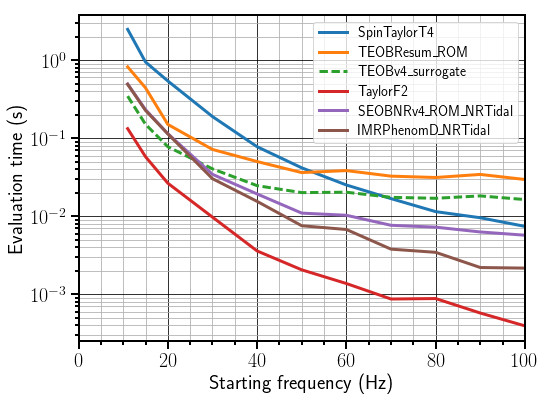

In [44]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(111)

axes.plot(flows, times_of_flow[:, 0], lw=3, label='SpinTaylorT4')
axes.plot(flows, times_of_flow[:, 1], lw=3, label='TEOBResum\_ROM')
axes.plot(flows, times_of_flow[:, 2], lw=3, ls='--', label='TEOBv4\_surrogate')
axes.plot(flows, times_of_flow[:, 3], lw=3, label='TaylorF2')
axes.plot(flows, times_of_flow[:, 4], lw=3, label='SEOBNRv4\_ROM\_NRTidal')
axes.plot(flows, times_of_flow[:, 5], lw=3, label='IMRPhenomD\_NRTidal')

axes.set_yscale('log')
axes.set_xlim([0., 100.0])
#axes.set_ylim([0.03, 10.0])
axes.minorticks_on()
axes.set_xlabel(r'Starting frequency (Hz)')
axes.set_ylabel(r'Evaluation time (s)')
axes.legend(loc='upper right')
axes.grid(which='major', c='k')
axes.grid(which='minor')

In [42]:
lalwaveform.print_all_approximants()

0 TaylorT1
1 TaylorT2
2 TaylorT3
3 TaylorF1
4 EccentricFD
5 TaylorF2
6 TaylorF2NLTides
7 TaylorR2F4
8 TaylorF2RedSpin
9 TaylorF2RedSpinTidal
10 PadeT1
11 PadeF1
12 EOB
13 BCV
14 BCVSpin
15 SpinTaylorT1
16 SpinTaylorT2
17 SpinTaylorT3
18 SpinTaylorT4
19 SpinTaylorT5
20 SpinTaylorF2
21 SpinTaylorFrameless
22 SpinTaylor
23 PhenSpinTaylor
24 PhenSpinTaylorRD
25 SpinQuadTaylor
26 FindChirpSP
27 FindChirpPTF
28 GeneratePPN
29 BCVC
30 FrameFile
31 AmpCorPPN
32 NumRel
33 NumRelNinja2
34 Eccentricity
35 EOBNR
36 EOBNRv2
37 EOBNRv2HM
38 EOBNRv2_ROM
39 EOBNRv2HM_ROM
40 TEOBResum_ROM
41 SEOBNRv1
42 SEOBNRv2
43 SEOBNRv2_opt
44 SEOBNRv3
45 SEOBNRv3_pert
46 SEOBNRv3_opt
47 SEOBNRv3_opt_rk4
48 SEOBNRv4
49 SEOBNRv4_opt
50 TEOBv2
51 TEOBv4
52 SEOBNRv1_ROM_EffectiveSpin
53 SEOBNRv1_ROM_DoubleSpin
54 SEOBNRv2_ROM_EffectiveSpin
55 SEOBNRv2_ROM_DoubleSpin
56 SEOBNRv2_ROM_DoubleSpin_HI
57 Lackey_Tidal_2013_SEOBNRv2_ROM
58 SEOBNRv4_ROM
59 SEOBNRv4_ROM_NRTidal
60 HGimri
61 IMRPhenomA
62 IMRPhenomB
63 IMRPhenom